# Land Cover Modelling with U-Net #

This script purpose is to generate and train the land cover model. It will load the patches from the ```preprocess.ipynb``` script, split it into train and test sets, used to fit the model, assess the model, and visualize the difference between the actual test result and its prediction, and saved the model (for later used mayb

In [54]:
import rasterio as rio
import os
import json
import pandas as pd
from PIL import ImageColor
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.layers import Conv2D, Conv2DTranspose, Dropout, MaxPooling2D, Input, concatenate
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [55]:
# Location of data
lc_dir = 'data/lc.json'
lc_image_dir = 'https://storage.googleapis.com/gee-ramiqcom-bucket/youtube/lc_python/LC_Image_v1.tif'
palsar_dir = "https://storage.googleapis.com/gee-ramiqcom-bucket/youtube/lc_python/Palsar_Kerinci_2023_v1.tif"
landsat_dir = "https://storage.googleapis.com/gee-ramiqcom-bucket/youtube/lc_python/Landsat_Kerinci_2023_v1.tif"

In [56]:
# Load Land Cover Parameter
lc = json.load(open(lc_dir))
lc_df = pd.DataFrame(lc)
lc_df["values_normalize"] = lc_df.index + 1
lc_df["palette"] = "#" + lc_df["palette"]

# Mapping from old to new values
values = lc_df["values"].to_list()
values_norm = lc_df["values_normalize"].to_list()
palette = lc_df["palette"].to_list()
labels = lc_df["label"].to_list()
dict_values = {}
dict_label = {}
dict_palette = {}
dict_palette_hex = {}
for x in range(0, len(values)):
    dict_values[values[x]] = values_norm[x]
    dict_label[values_norm[x]] = labels[x]
    dict_palette[values_norm[x]] = ImageColor.getrgb(palette[x])
    dict_palette_hex[values_norm[x]] = palette[x]

# Create colormap from values and palette
cmap = ListedColormap(palette)

# Patches legend
patches = [
    mpatches.Patch(color=palette[i], label=labels[i]) for i in range(len(values))
]
legend = {
    "handles": patches,
    "bbox_to_anchor": (1.05, 1),
    "loc": 2,
    "borderaxespad": 0.0,
}

lc_df

palette  values                      label  values_normalize
0   #006400    2001     Primary dryland forest                 1
1   #228B22    2002   Secondary dryland forest                 2
2   #4B0082    2004    Primary mangrove forest                 3
3   #808000    2005       Primary swamp forest                 4
4   #32CD32    2006          Plantation forest                 5
5   #90EE90    2007                  Dry shrub                 6
6   #FF4500    2010                Estate crop                 7
7   #F08080    2012                 Settlement                 8
8   #D2B48C    2014                Bare ground                 9
9   #ADFF2F    3000        Savanna and grasses                10
10  #87CEFA    5001                 Open water                11
11  #6A5ACD   20041  Secondary mangrove forest                12
12  #6B8E23   20051     Secondary swamp forest                13
13  #66CDAA   20071                  Wet shrub                14
14  #FFD700   20091       Pure dry agriculture                15
15  #FFA500   20092      Mixed dry agriculture                16
16  #008080   20093                Paddy field                17
17  #E6E6FA   20094      Fish pond/aquaculture                18
18  #B22222   20121            Port or harbour                19
19  #C71585   20122       Transmigration areas                20
20  #A0522D   20141                     Mining                21
21  #7FFFD4   50011                      Swamp                22

In [57]:
# load image sample
lc_values = os.listdir('data/images')
lc_values = list(map(lambda x: int(x.split('_')[0]), lc_values))
lc_values = np.unique(lc_values)
lc_values.sort()
lc_values

array([ 1,  2,  5,  6,  7,  8,  9, 11, 14, 15, 16, 17, 20, 22])

### Augmentation Function ###

While we have quite many samples, we need more diverse sample to make sure the model is actually learning instead of just remembering.

To achieve that, the sample/patches will be flipped and rotated and added to the rest of samples.

In [58]:
# Function to augment and add more sample
def augment(array, list):
	flip = np.flip(array, 1)
	for arr in [array, flip]:
		for rot in [1, 2, 3]:
			list.append(np.rot90(arr, rot))

### Load the patches, train/test split, and augmentation ###

The loaded patches, either the landsat image and land cover label, will be split into train and test data using 4:1 ratio. 

After split, all of the data will be augmented to increase sample size and to make the model learn better.

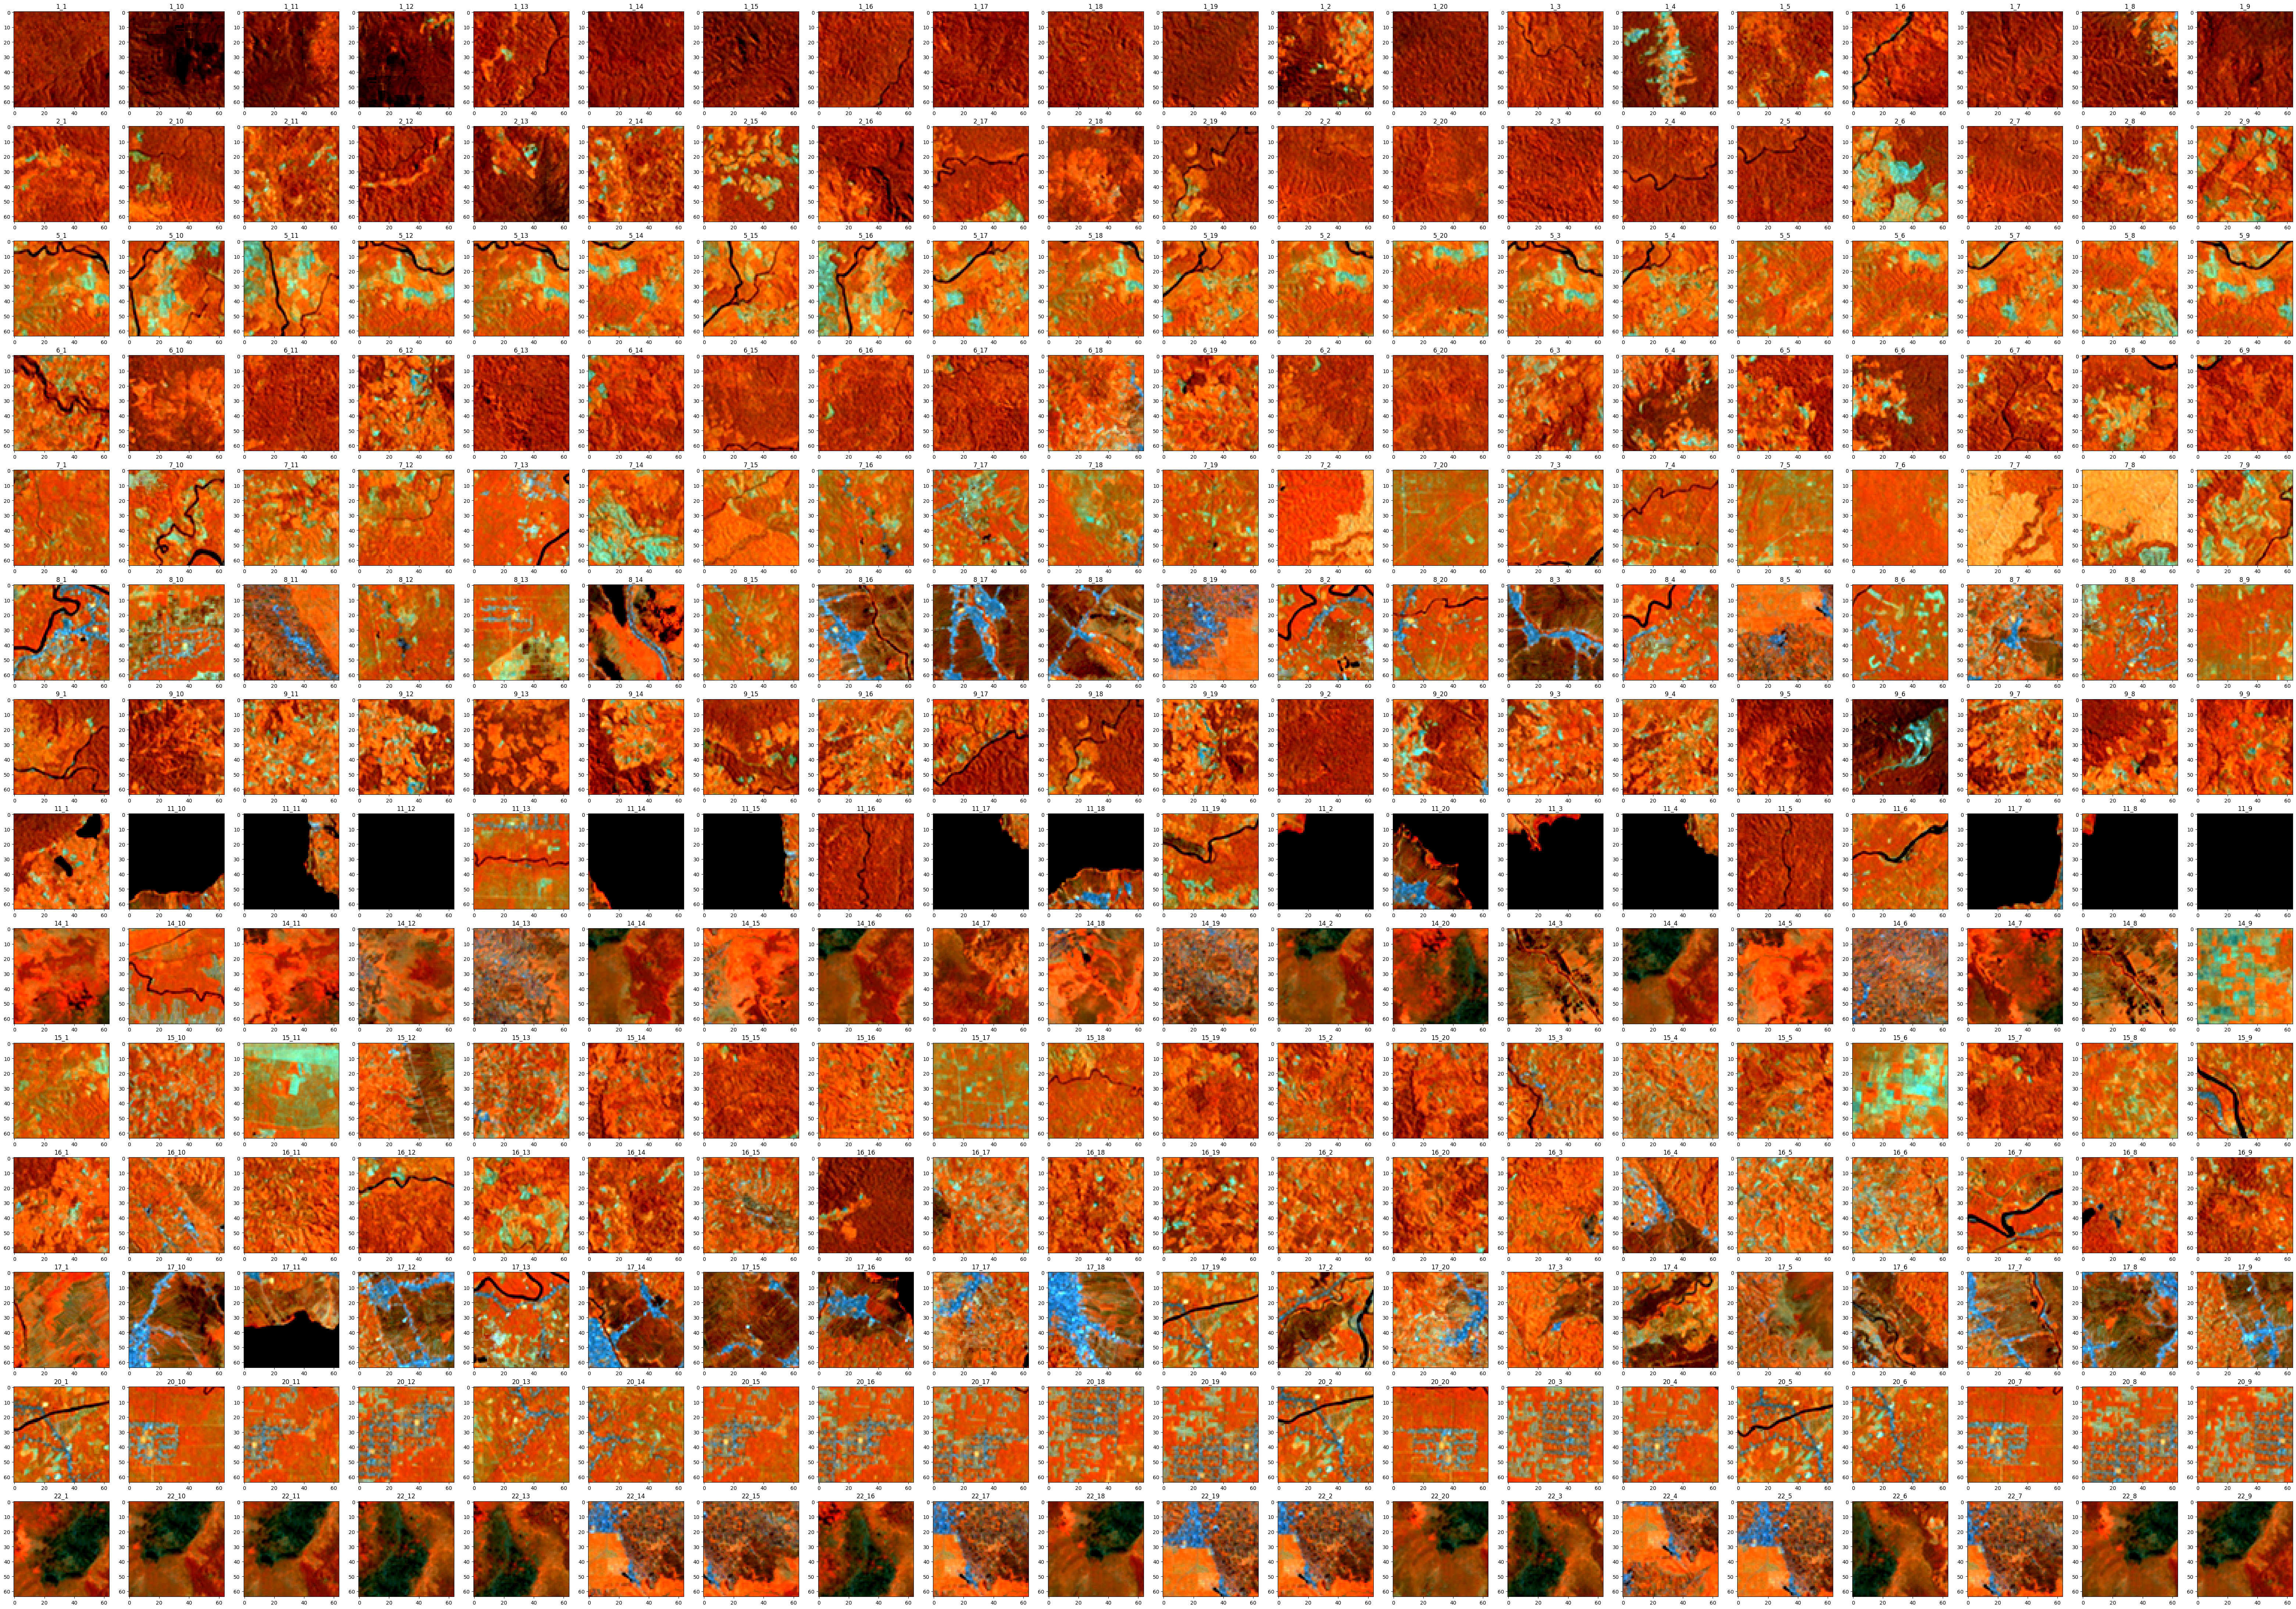

In [61]:
# Define image per land cover
image_per_lc = 20
index_train = int(8 / 10 * image_per_lc)

plt.figure(figsize=(4 * image_per_lc, 4 * len(lc_values)))

# List of images
images_train = []
images_test = []

# Load image first
for x in range(0, len(lc_values)):
	lc = lc_values[x]
	images_list = os.listdir('data/images')
	images_list = list(filter(lambda x: int(x.split('_')[0]) == lc, images_list))

	for y in range(0, len(images_list)):
		dir = images_list[y]
		name = dir.split('.')[0]
		image_dir = f'data/images/{dir}'
		source = rio.open(image_dir)

		# Make it into a image shape to plot
		image = np.transpose(source.read(), (1, 2, 0))

		# Augment then add to the list
		augment(image, images_train if (y < index_train) else images_test)

		# Plot the image
		plt.subplot(len(lc_values), image_per_lc, x * image_per_lc + y + 1)
		plt.imshow(image)
		plt.title(f'{name}')

		source.close()

# Turn in into numpy array stacks
images_train = np.stack(images_train)
images_test = np.stack(images_test)

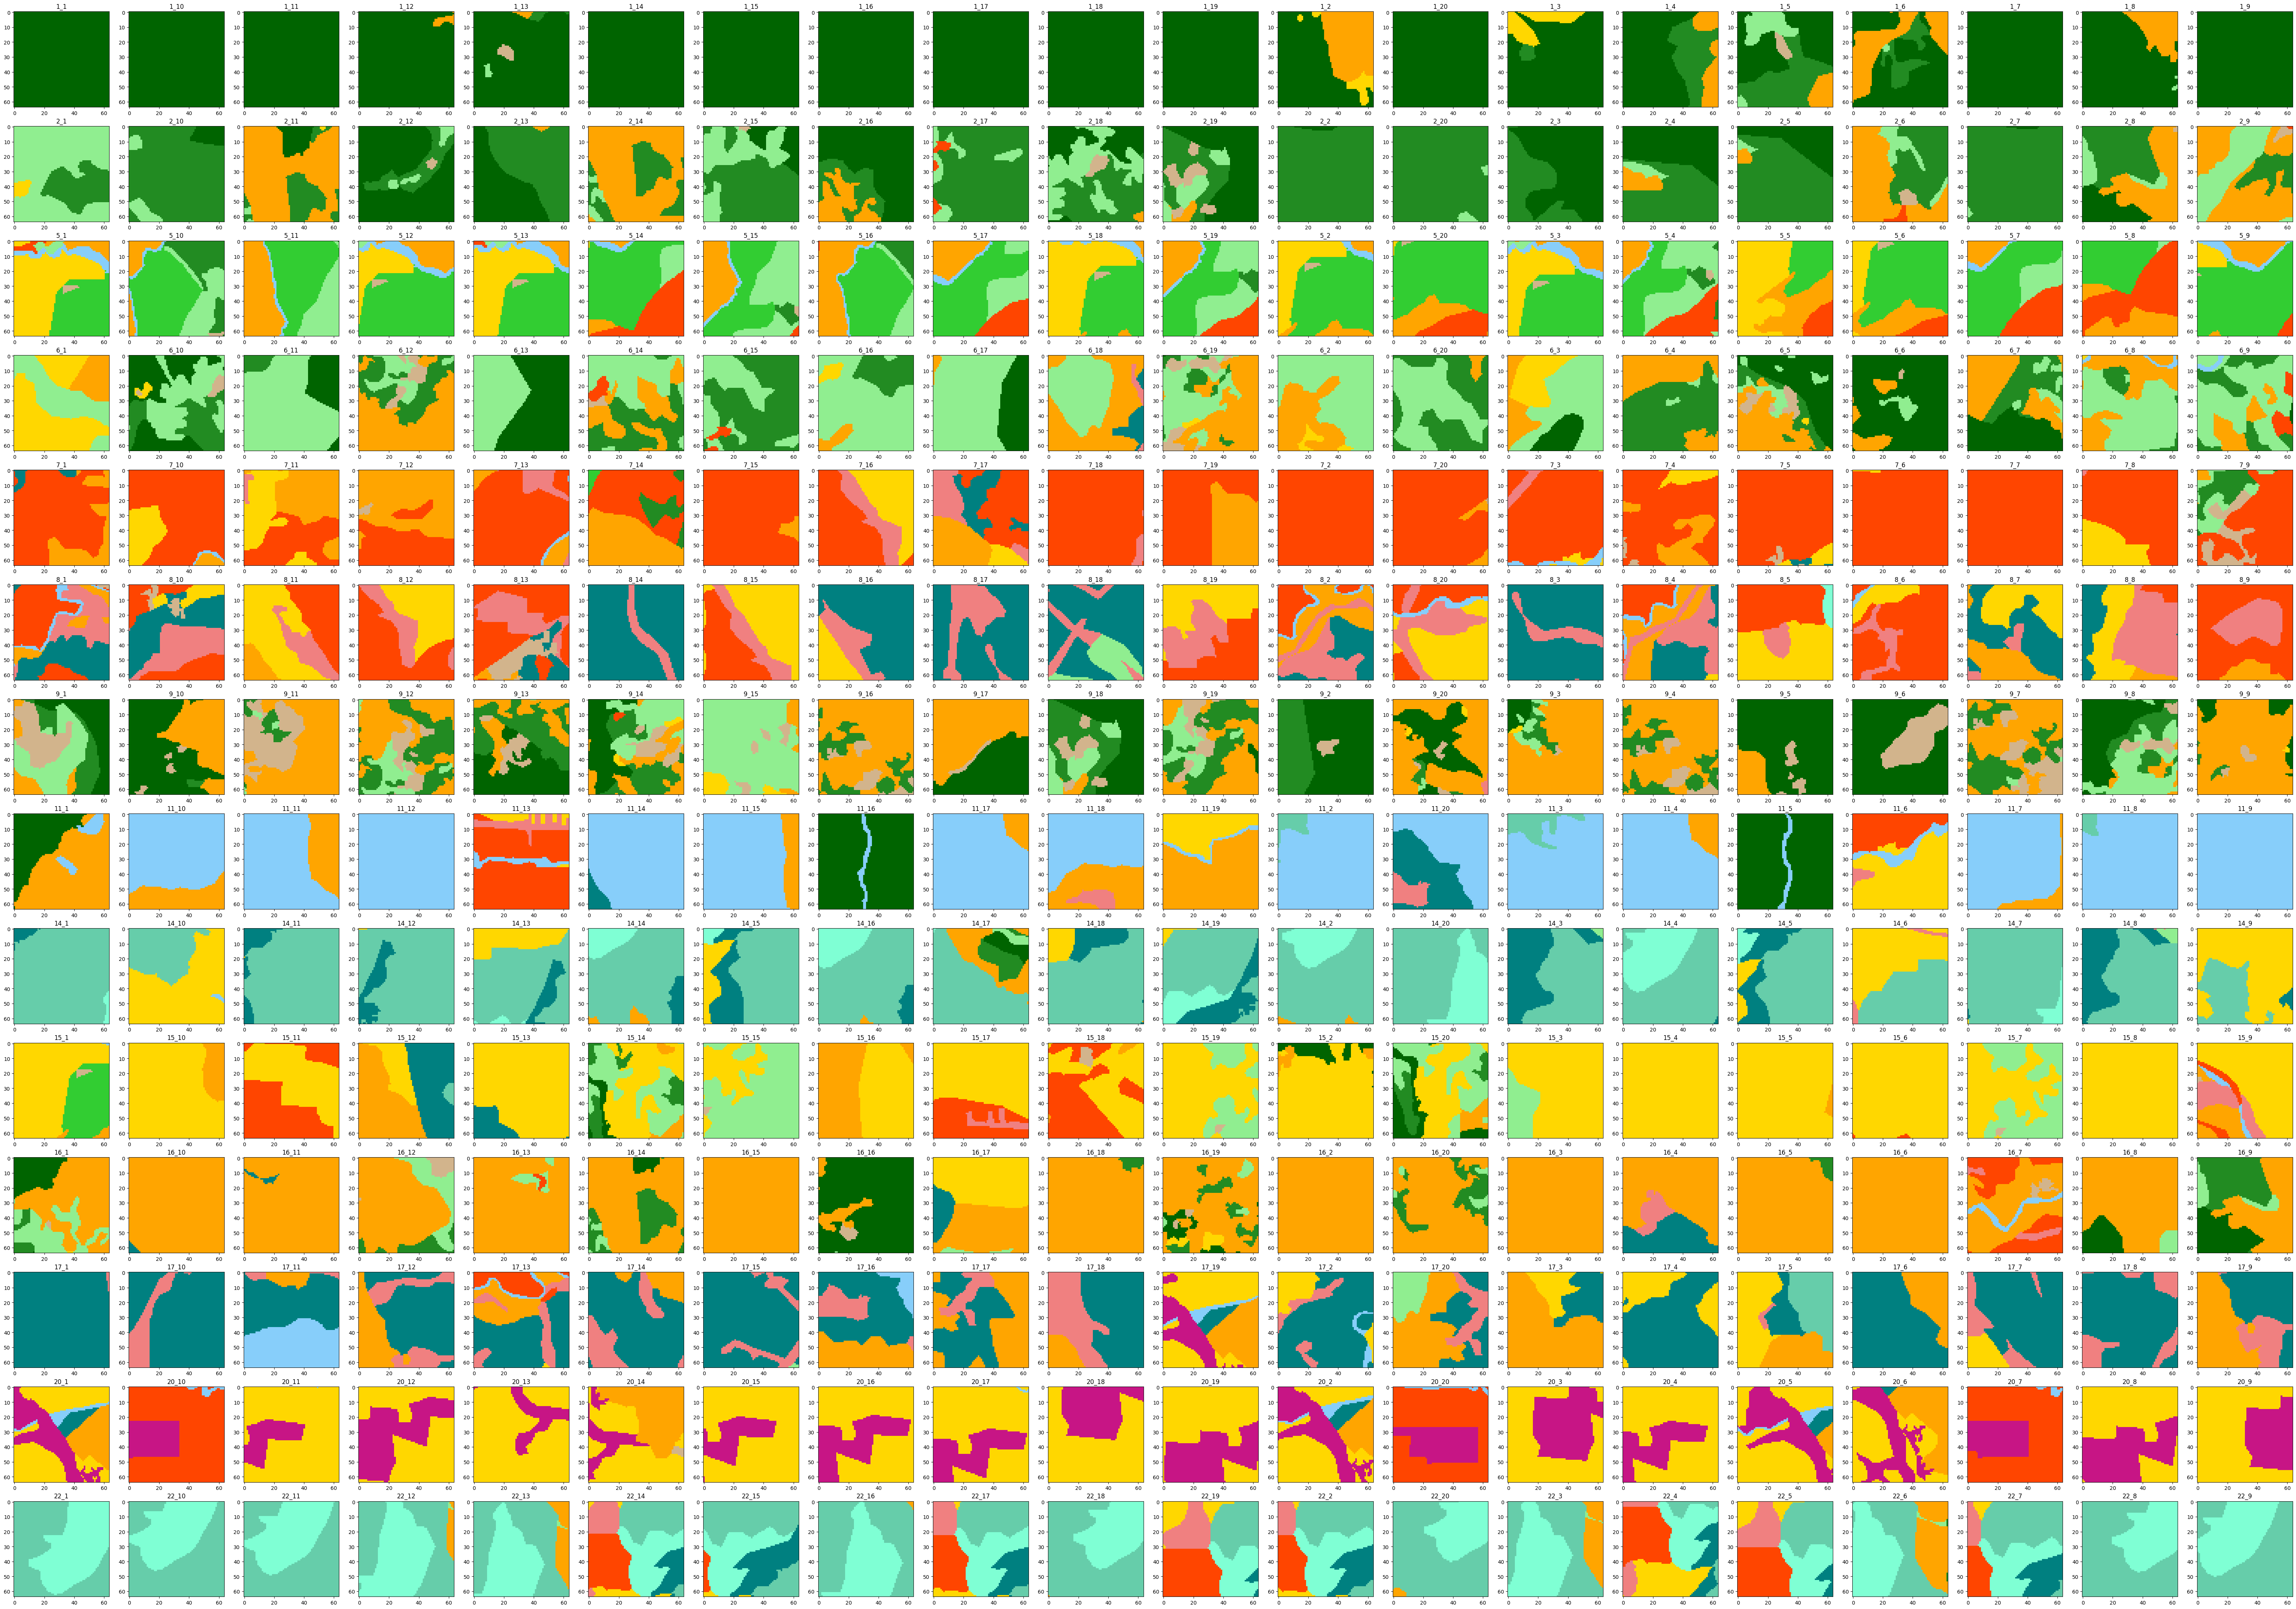

In [62]:
# Load lc first
plt.figure(figsize=(4 * image_per_lc, 4 * len(lc_values)))

lcs_train = []
lcs_test = []

for x in range(0, len(lc_values)):
	lc = lc_values[x]
	images_list = os.listdir('data/lcs')
	images_list = list(filter(lambda x: int(x.split('_')[0]) == lc, images_list))

	for y in range(0, len(images_list)):
		dir = images_list[y]
		name = dir.split('.')[0]
		image_dir = f'data/lcs/{dir}'
		source = rio.open(image_dir)
		image = source.read()

		# Transposed the image into an image object
		transposed = np.transpose(image, (1, 2, 0))

		# Augment then add to the list
		augment(transposed, lcs_train if (y < index_train) else lcs_test)

		# Plot the land cover
		plt.subplot(len(lc_values), image_per_lc, x * image_per_lc + y + 1)
		plt.imshow(image[0], cmap=cmap, interpolation='nearest', vmin=1, vmax=22)
		plt.title(f'{name}')

		source.close()

lcs_train = np.stack(lcs_train)
lcs_test = np.stack(lcs_test)

In [63]:
print(f'Train_predictors_shape: {images_train.shape}\nTrain_label_shape: {lcs_train.shape}\nTest_predictors_shape: {images_test.shape}\nTest_label_shape: {lcs_test.shape}')

Train_predictors_shape: (1344, 64, 64, 3)
Train_label_shape: (1344, 64, 64, 1)
Test_predictors_shape: (336, 64, 64, 3)
Test_label_shape: (336, 64, 64, 1)


In [ ]:
# Make lcs data into categorical
# Keras model use different output data shape for category data
# Convert it using utility from keras to make into categorical shape
lcs_train_category = to_categorical(lcs_train)
lcs_test_category = to_categorical(lcs_test)

### Create U-Net Model ###

This script contain the function, parameter, and structure of the U-Net model to classify land cover from Landsat imagery.

You can change the neuron and kernel if you want to adjust how many layers or window where the model learn.

More layers mean bigger model and bigger kernel mean more generalized model.

In [65]:
# Make keras model
input_shape = images_train.shape
input_shape = (input_shape[1], input_shape[2], input_shape[3])

neuron = 64
kernel = 3
kernel_t = 2
dropout = 0.1
strides = 2
pool = 2
padding = 'same'

input_layer = Input(input_shape)

def conv2_block(input, neuron, last=False):
	conv1 = Conv2D(neuron, kernel, activation='relu', padding=padding)(input)
	conv2 = Conv2D(neuron, kernel, activation='relu', padding=padding)(conv1)
	return conv2

def encode(input, neuron):
	conv1 = conv2_block(input, neuron)
	mp = MaxPooling2D(2)(conv1)
	dp = Dropout(dropout)(mp)
	return conv1, dp

def decode(input, conv, neuron):
	conv_t = Conv2DTranspose(neuron, kernel_t, strides, activation='relu', padding=padding)(input)
	concat = concatenate([conv_t, conv])
	conv2 = conv2_block(concat, neuron)
	dp = Dropout(dropout)(conv2)
	return dp

conv1, mp1 = encode(input_layer, neuron * 1)
conv2, mp2 = encode(mp1, neuron * 2)
conv3, mp3 = encode(mp2, neuron * 4)

transition = conv2_block(mp3, neuron * 8)

uncov1 = decode(transition, conv3, neuron * 4)
uncov2 = decode(uncov1, conv2, neuron * 2)
uncov3 = decode(uncov2, conv1, neuron * 1)

output = Conv2D(lcs_train_category.shape[3], 1, padding=padding, activation='softmax')(uncov3)

model = Model(input_layer, output)
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_63 (Conv2D)  │ (None, 64, 64,    │      1,792 │ input_layer_5[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_64 (Conv2D)  │ (None, 64, 64,    │     36,928 │ conv2d_63[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 32, 32,    │          0 │ conv2d_64[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_24          │ (None, 32, 32,    │          0 │ max_pooling2d_12… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_65 (Conv2D)  │ (None, 32, 32,    │     73,856 │ dropout_24[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_66 (Conv2D)  │ (None, 32, 32,    │    147,584 │ conv2d_65[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 16, 16,    │          0 │ conv2d_66[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 16, 16,    │          0 │ max_pooling2d_13… │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_67 (Conv2D)  │ (None, 16, 16,    │    295,168 │ dropout_25[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_68 (Conv2D)  │ (None, 16, 16,    │    590,080 │ conv2d_67[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 8, 8, 256) │          0 │ conv2d_68[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_26          │ (None, 8, 8, 256) │          0 │ max_pooling2d_14… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_69 (Conv2D)  │ (None, 8, 8, 512) │  1,180,160 │ dropout_26[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_70 (Conv2D)  │ (None, 8, 8, 512) │  2,359,808 │ conv2d_69[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_12 │ (None, 16, 16,    │    524,544 │ conv2d_70[0][0]   │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_12      │ (None, 16, 16,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 512)              │            │ conv2d_68[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 7,698,775 (29.37 MB)

 Trainable params: 7,698,775 (29.37 MB)

 Non-trainable params: 0 (0.00 B)

### Complie and Train Model ###

Created model need to be complied and trained using patches we made before.

You adjust how many epochs that you train the model, learning rate in the optimizers, batch size (how many patches trained at one time), and validation split (how many sample are used for validation).

After the training is done, you will asses it.

In [66]:
# Compile and build the model
model.compile(
	optimizer=keras.optimizers.Adam(0.0001),
	loss=keras.losses.CategoricalCrossentropy(),
	metrics=[keras.metrics.CategoricalAccuracy()
])

callbacks = [
	EarlyStopping(patience=5, monitor='categorical_accuracy')
]

result = model.fit(
	x=images_train,
	y=lcs_train_category,
	epochs=100,
	batch_size=16,
	shuffle=True,
	validation_split=0.1,
	callbacks=callbacks
)

Epoch 1/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 46s 559ms/step - categorical_accuracy: 0.1218 - loss: 3.0170 - val_categorical_accuracy: 0.1636 - val_loss: 2.9852
Epoch 2/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 45s 597ms/step - categorical_accuracy: 0.1711 - loss: 2.5197 - val_categorical_accuracy: 0.1055 - val_loss: 2.9845
Epoch 3/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 45s 588ms/step - categorical_accuracy: 0.3116 - loss: 2.1660 - val_categorical_accuracy: 0.1116 - val_loss: 3.0770
Epoch 4/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 48s 628ms/step - categorical_accuracy: 0.3300 - loss: 1.9584 - val_categorical_accuracy: 0.1717 - val_loss: 2.8153
Epoch 5/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 46s 605ms/step - categorical_accuracy: 0.3500 - loss: 1.8648 - val_categorical_accuracy: 0.1120 - val_loss: 2.6901
Epoch 6/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 42s 551ms/step - categorical_accuracy: 0.3498 - loss: 1.8652 - val_categorical_accuracy: 0.1750 - val_loss: 2.6485
Epoch 7/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 45s 599ms/step - categorical_accuracy

    categorical_accuracy      loss  val_categorical_accuracy  val_loss
0               0.135424  2.867828                  0.163551  2.985240
1               0.206913  2.421515                  0.105534  2.984465
2               0.314934  2.129378                  0.111554  3.077036
3               0.343753  1.919645                  0.171663  2.815349
4               0.348701  1.863503                  0.112010  2.690144
..                   ...       ...                       ...       ...
95              0.939300  0.168441                  0.754514  1.274870
96              0.938653  0.170202                  0.764596  1.250089
97              0.925521  0.210864                  0.742354  1.304456
98              0.935345  0.179685                  0.758740  1.223724
99              0.939473  0.167119                  0.764954  1.252551

[100 rows x 4 columns]


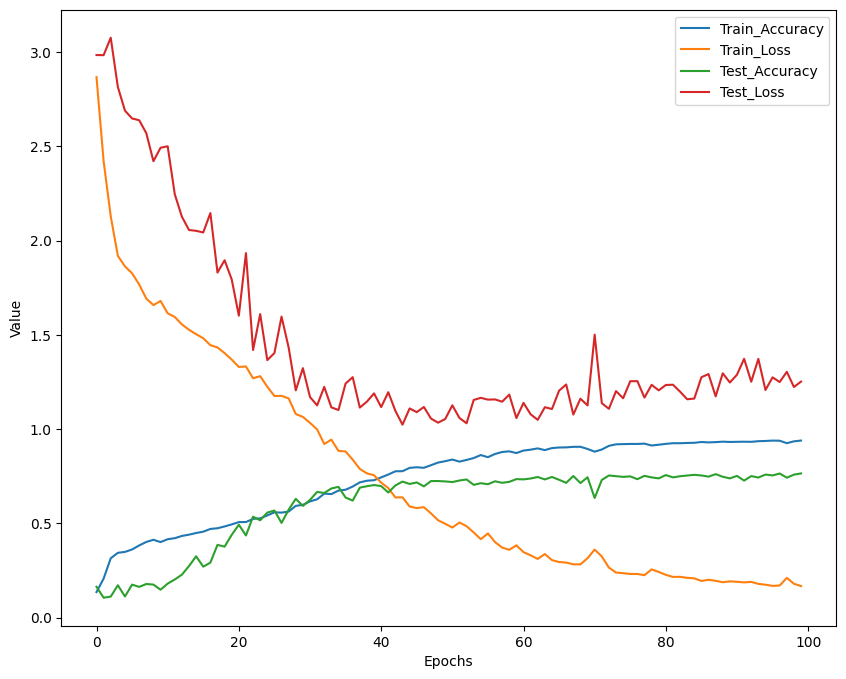

In [67]:
# Show history
history = pd.DataFrame(result.history)
print(history)

plt.figure(figsize = (10, 8))
plt.plot(range(len(history['categorical_accuracy'].values.tolist())), history['categorical_accuracy'].values.tolist(), label = 'Train_Accuracy')
plt.plot(range(len(history['loss'].values.tolist())), history['loss'].values.tolist(), label = 'Train_Loss')
plt.plot(range(len(history['val_categorical_accuracy'].values.tolist())), history['val_categorical_accuracy'].values.tolist(), label = 'Test_Accuracy')
plt.plot(range(len(history['val_loss'].values.tolist())), history['val_loss'].values.tolist(), label = 'Test_Loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

### Assess the Model Performance with Test Data ###

After the model is trained, then it will be apply to the test data.

The applied test data then compared to the true land cover label patches of the test data.

The assessment is done using classification report and confusion matrix

In [68]:
# Predict test data
prediction = np.argmax(model.predict(images_test), 3).flatten()
label = lcs_test.flatten()

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 299ms/step


              precision    recall  f1-score   support

           1       0.92      0.69      0.79    156462
           2       0.43      0.62      0.51     85674
           5       0.81      0.90      0.85     54216
           6       0.39      0.36      0.37     73140
           7       0.61      0.66      0.63    176538
           8       0.64      0.46      0.53     41790
           9       0.09      0.07      0.08     19182
          11       0.93      0.95      0.94     78708
          14       0.83      0.79      0.81    107550
          15       0.55      0.47      0.51    191892
          16       0.49      0.55      0.52    229908
          17       0.79      0.84      0.81     93456
          20       0.87      0.87      0.87     31692
          22       0.90      0.82      0.86     36048

    accuracy                           0.64   1376256
   macro avg       0.66      0.65      0.65   1376256
weighted avg       0.66      0.64      0.64   1376256



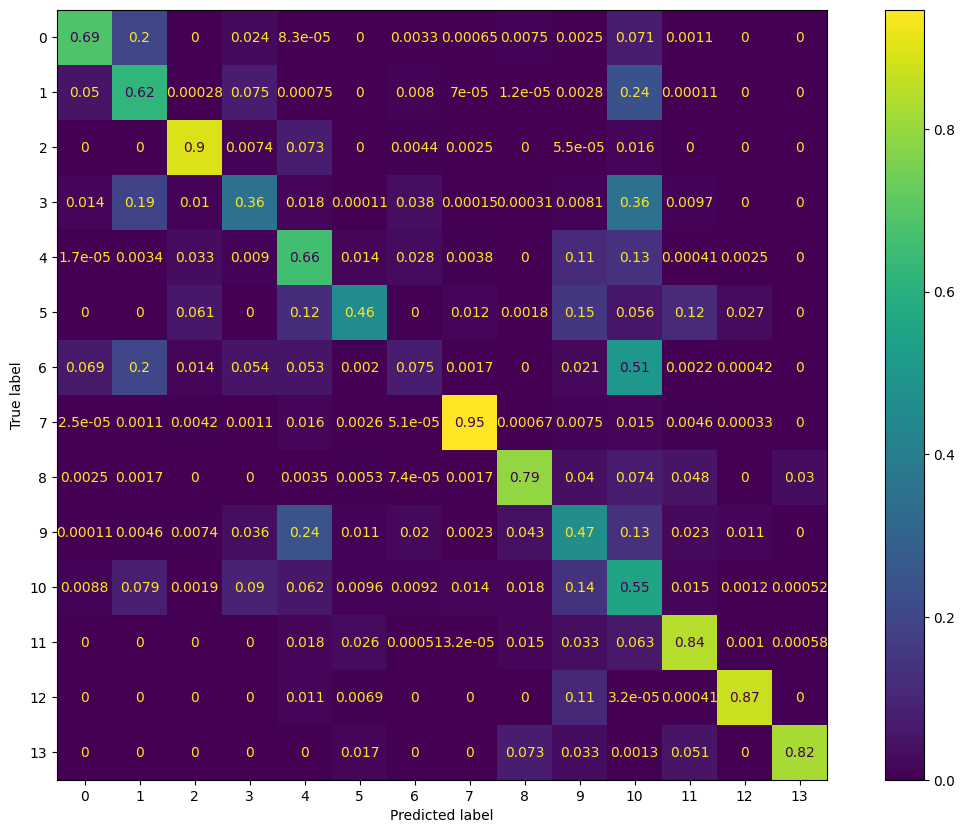

In [69]:
# Confusion matrix
cm = confusion_matrix(label, prediction, normalize='true')
fig, ax = plt.subplots(figsize=(15, 10))
cm = ConfusionMatrixDisplay(cm)
cm.plot(ax = ax)

# Classification report
print(classification_report(label, prediction))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━

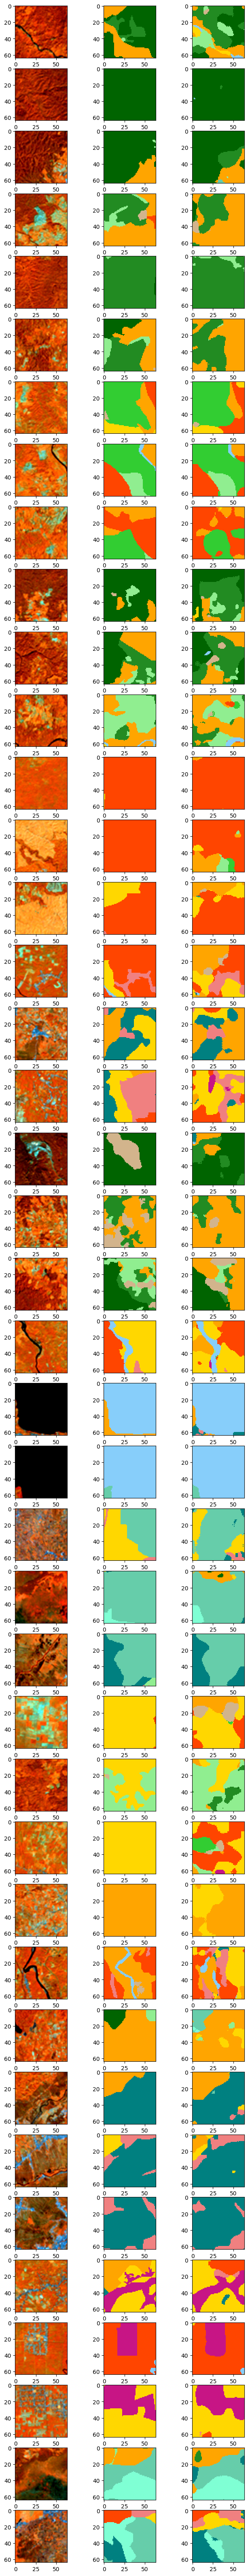

In [70]:
image_non_augment_size = int(len(images_test) / 8)

plt.figure(figsize=(8, image_non_augment_size * 2))

# Apply to classified image of the image
for x in range(0, image_non_augment_size - 1):
	index = x * 8

	image = images_test[index:(index + 1)]
	pred = model.predict(image)
	pred = np.argmax(pred, 3)[0]

	plt.subplot(image_non_augment_size, 3, x * 3 + 1)
	plt.imshow(image[0])

	plt.subplot(image_non_augment_size, 3, x * 3 + 2)
	plt.imshow(lcs_test[index], cmap=cmap, interpolation='nearest', vmin=1, vmax=22)

	plt.subplot(image_non_augment_size, 3, x * 3 + 3)
	plt.imshow(pred, cmap=cmap, interpolation='nearest', vmin=1, vmax=22)

In [71]:
# Save model
model.save('data/dl_unet_landcover_model_v1.keras')